# EDA Notebook for Dengue Transfer Learning Project

## Task

Conduct EDA for TensorFlow transfer learning pipeline to forecast **weekly dengue cases** (`total_cases`) from 22 multivariate weather/environmental features.

### Dataset
Dengue ML datasets track environmental and temporal factors influencing Aedes mosquito breeding and virus transmission in tropical regions like San Juan and Iquitos.

- #### Temporal Features
    - **city**: Location identifier (e.g., 'sj' for San Juan, 'iq' for Iquitos)—captures city-specific mosquito/dengue patterns.
    - **year, weekofyear, week_start_date**: Time granularity for seasonality; dengue peaks during rainy seasons (weekofyear critical for lagged effects).

- #### Vegetation Indices (NDVI)
    - **ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw**: Normalized Difference Vegetation Index by city quadrant. Higher NDVI indicates lush vegetation providing mosquito shade/breeding sites; key for Aedes habitat detection via satellite.

- #### Precipitation \& Water
    - **precipitation_amt_mm**: Rainfall amount—creates standing water breeding sites.
    - **reanalysis_precip_amt_kg_per_m2, reanalysis_sat_precip_amt_mm**: Reanalysis (modeled) precipitation variants confirming observed rain.
    - **station_precip_mm**: Ground station measurements—most direct rain proxy.

- #### Temperature Metrics
    - **reanalysis_air_temp_k, reanalysis_avg_temp_k, reanalysis_max_air_temp_k, reanalysis_min_air_temp_k**: Reanalysis temps in Kelvin; optimal Aedes range 26-32°C accelerates larval development/virus replication.
    - **station_avg_temp_c, station_max_temp_c, station_min_temp_c**: Station temps in Celsius—ground truth validation.
    - **station_diur_temp_rng_c**: Diurnal range; wider swings stress mosquitoes.
    - **reanalysis_tdtr_k**: Temperature diurnal temperature range (reanalysis).

- #### Humidity \& Moisture
    - **reanalysis_dew_point_temp_k**: Dew point—direct humidity proxy; high values (>20°C) favor mosquito survival.
    - **reanalysis_relative_humidity_percent**: Relative humidity %—critical for egg/larval viability.
    - **reanalysis_specific_humidity_g_per_kg**: Absolute moisture content.


### Notebook sections for the first project notebook (EDA)
1. Get Data
2. Exploratory Data Analysis

In [1]:
import sys
import os
from pathlib import Path
from typing import List, Tuple, Any, Union
import gc

# Set one level up as project root|
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))
    
from src.config import ProjectConfig  # project config file parser
from src.utils.utils import load_file
from src.utils.eda import value_streaks, top_correlations
from src.utils.visualizations import compute_correlations_matrix, \
                display_distributions, random_color, random_colormap, \
                display_timeseries

import pandas as pd
import numpy as np
import random
import time
from datetime import timedelta

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from matplotlib.axis import Axis
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import seaborn as sns

In [2]:
cnfg = ProjectConfig.load_configuration()
PATH_TO_RAW_DATA = cnfg.data.dirs["raw"]
FILE_TRAIN_RAW= cnfg.data.files["features_train"]
FILE_TEST_RAW = cnfg.data.files["features_test"]
FILE_LABELS_RAW = cnfg.data.files["labels_train"]
TARGET = cnfg.preprocess.feature_groups["target"]
ENV_FEAT_PREFIX = cnfg.preprocess.feature_groups["env_prefixes"]
CITYGROUP_FEAT = cnfg.preprocess.feature_groups["city"]
DATETIME_FEAT = cnfg.preprocess.feature_groups["datetime"]

### Get Data

In [3]:
# # TODO remove after cleaning
# # moved to  src.utils.utils

# def load_file(path: Union[str, Path], datetime_col: str=None) -> pd.DataFrame:
#     """
#     Load data from CSV or Parquet file into a pandas DataFrame.  
#     :param path: File path as string or Path object.
#     :param datetime_col: Name of column to parse as datetime with CSV files. 
#                         Optional; pass None to skip.
#     :return: Loaded DataFrame with data from the file.
#     :raises FileNotFoundError: If file does not exist.
#     :raises ValueError: If file format is unsupported (.csv or .parquet only).
#     """
#     path = Path(path)
#     if not path.is_file():
#         raise FileNotFoundError(f"No such file: {path}")
#     if path.suffix.lower() == ".csv":
#         data = pd.read_csv(path, parse_dates=[datetime_col] if datetime_col else None)
#     elif path.suffix.lower() == ".parquet":
#         data = pd.read_parquet(path, engine='fastparquet')
#     else:
#         raise ValueError(f"Unsuported file forlat: {path.suffix}")

#     return data

In [4]:
df_train_raw = load_file(path=PATH_TO_RAW_DATA / FILE_TRAIN_RAW, datetime_col=DATETIME_FEAT)
df_test_raw = load_file(path=PATH_TO_RAW_DATA / FILE_TEST_RAW, datetime_col=DATETIME_FEAT)
df_labels_raw = load_file(path=PATH_TO_RAW_DATA / FILE_LABELS_RAW)
list_raw_df = [df_train_raw, df_test_raw, df_labels_raw]

In [5]:
for df in list_raw_df:
    display(df.sample(1))   

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
43,sj,1991,9,1991-02-26,0.1702,0.2086,0.13752,0.191433,31.79,297.505714,...,23.8,77.977143,31.79,14.794286,2.114286,25.257143,7.2,30.6,20.0,30.7


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
370,iq,2012,32,2012-08-12,0.2895,0.300171,0.239743,0.308771,16.38,297.657143,...,8.9,77.642857,16.38,14.56,13.114286,27.0,13.4,34.2,18.3,NaN


,city,year,weekofyear,total_cases
15,sj,1990,33,13


### Exploratory Data Analysis

***To reduce data snooping, slice last entries for both dataset cities***

In [6]:
holdout_pct = 0.05
cities_first_i = df_train_raw.groupby(by=CITYGROUP_FEAT)["week_start_date"].idxmin()  # Series w Start indices
cities_last_i = df_train_raw.groupby(by=CITYGROUP_FEAT)["week_start_date"].idxmax()  # Series w end indices
cities_last_i = (cities_last_i - (cities_last_i - cities_first_i) * holdout_pct).astype(int)  # indice math with Series
period = tuple(slice(cities_first_i[city], cities_last_i[city], 1) for city in cities_last_i.index[::-1])  # Create tuple of slices from 2 Series
df_train_raw_eda = df_train_raw.iloc[np.r_[period]].reset_index(drop=True)  # apply defuned slices
df_labels_raw_eda = df_labels_raw.iloc[np.r_[period]].reset_index(drop=True)
list_raw_df = [df_train_raw_eda, df_test_raw, df_labels_raw_eda]

- #### Dataframe level EDA

In [7]:
for df in list_raw_df:
    print(df.dtypes, '\n' , '+' * 120)

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

**Conclusion**: Datatypes look clean

In [8]:
df_labels_raw_eda.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
year,1381.000000,2000.637219,5.265367,1990.000000,1996.000000,2002.000000,2005.000000,2009.000000
weekofyear,1381.000000,26.690080,14.974697,1.000000,14.000000,27.000000,40.000000,53.000000
total_cases,1381.000000,24.523534,44.008073,0.000000,5.000000,12.000000,28.000000,461.000000


**Conclusion**: Skewed target, outliers

In [9]:
#df_train_raw_eda.describe().T

In [10]:
df_labels_raw_eda[["city", "year", "weekofyear"]].equals(df_train_raw_eda[["city", "year", "weekofyear"]])

True

**Conclusion**: Non-target columns in target file and corresponding columns in training file appear to be matching. No issue here.

In [11]:
df_train_raw_eda.sort_values(["city", "week_start_date"], ascending=[False, True]).equals(df_train_raw_eda)

True

**Conclusion**: Data already sorted City-wise and time-wise

for df in list_raw_df:
    shp = df.shape
    print(f"Dataframe shape: {shp}")
    print("\n\tNaN percentages in Dataframe:")
    print(round(((df.isna().sum() / shp[0]).sort_values(ascending=False) * 100), 2))
    print('=' * 120)

**Conclusion**: NaN issue

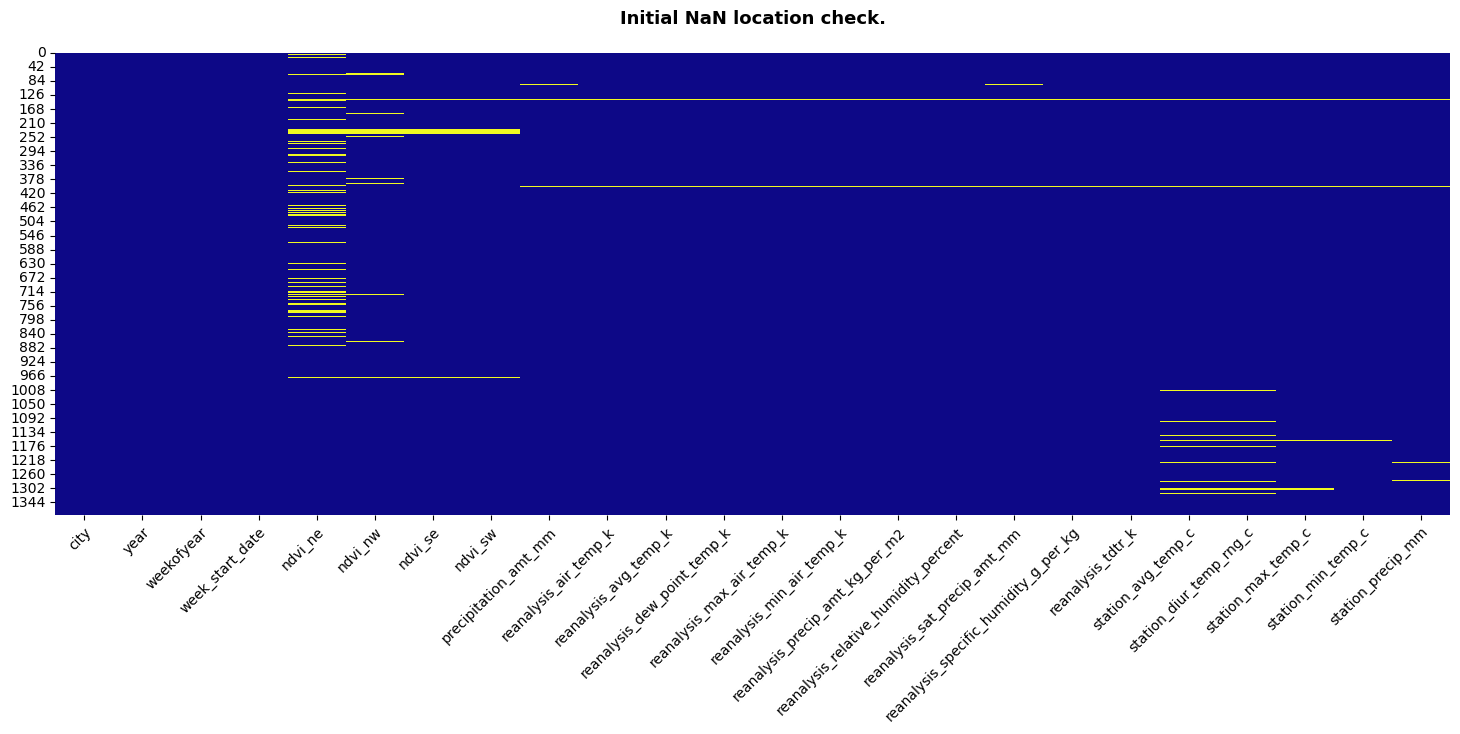

In [12]:
plt.figure(figsize=(18, 6))  # df_train_raw_eda.shape[1]
sns.heatmap(df_train_raw_eda.isna(), cmap='plasma', cbar=False)
plt.title("Initial NaN location check.\n", 
          fontsize=13, fontweight="bold")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [13]:
# for city, group in df_train_raw_eda.groupby(by=CITYGROUP_FEAT):
#     shp = group.shape
#     print(f"Dataframe shape for {city}: {shp}")
#     print("\n\tNaN percentages in Dataframe:")
#     print(round(((group.isnull().sum() / shp[0]).sort_values(ascending=False) * 100), 2))
#     print('=' * 120)

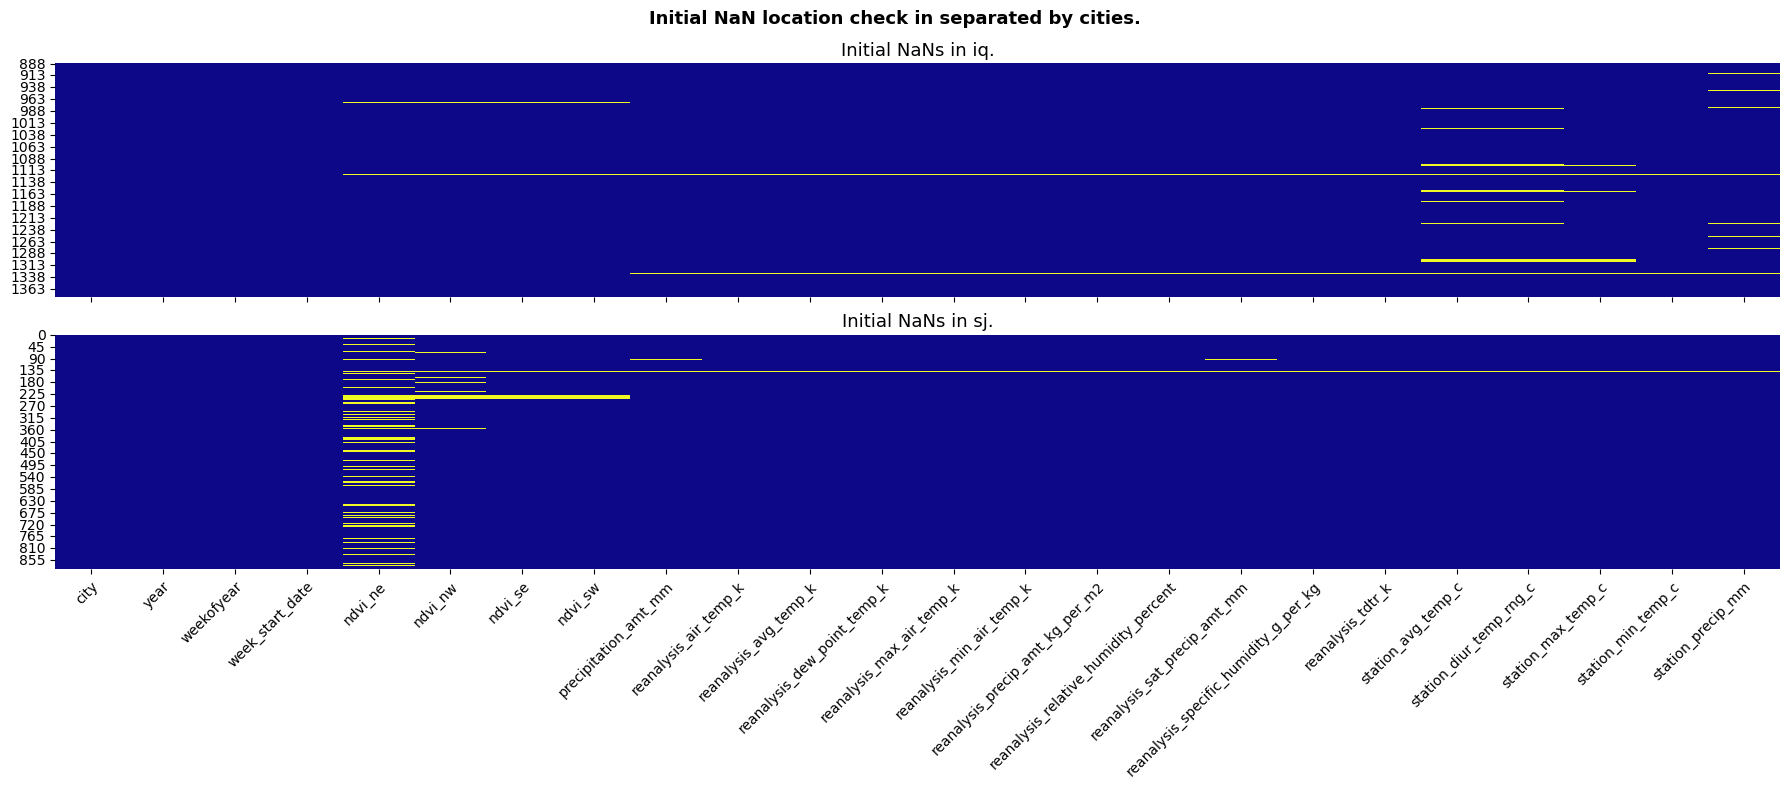

In [14]:
n_subplots = df_train_raw_eda[CITYGROUP_FEAT].nunique()
fig, axs = plt.subplots(nrows=n_subplots, figsize = (18, n_subplots * 4), 
                            sharex=True)
index = 0
for city, group in df_train_raw_eda.groupby(by=CITYGROUP_FEAT):
    sns.heatmap(group.isna(), cmap='plasma', cbar=False, ax=axs[index])
    axs[index].set_title(f"Initial NaNs in {city}.", 
              fontsize=13)
    index += 1
    
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.suptitle(f"Initial NaN location check in separated by cities.", 
          fontsize=13, fontweight="bold")
fig.tight_layout()
plt.show()

**Conclusion**:
- potential for row-wise remowal where most of datapoint features lack values
- columnwise *"ndvi_ne"* feature:
    - sparse, but importand (vegetation data crucial for mosquitoes) - attempt to interpolate from other rows of the same feature
- possible imputation for temperatures where reanalysis data available
- possible reconstruction of temperatures, where station min and max temperatires available, but ranges and averages are not
- Missing value patterns between San Juan and Iquitos do differ:
    - Iquitos is mostly missing station measurement data
    - Station measurement data are good for San Juan
    - San Juan is mostly missing vegetation (ndvi) data
    - Vegetation (ndvi) data are good for Iquitos

In [15]:
filter_threshold = 0.9  # percent
high_nan_features = df_train_raw_eda.isna().mean().loc[lambda x: x > filter_threshold / 100].index.tolist()
# mean() in case of boolean 0/1 value is the same as frequency proportion calculation

In [16]:
nan_threshold = 3
for col in df_train_raw_eda.columns:
    temp_df = value_streaks(data=df_train_raw_eda, column=col, value=np.nan,
                                 run_threshold=nan_threshold)
    if len(temp_df) > 0:
        print(f"NaN streaks longer than {nan_threshold} weeks for {col} feature:")          
        display(value_streaks(data=df_train_raw_eda, column=col, value=np.nan,
                                     run_threshold=nan_threshold))

NaN streaks longer than 3 weeks for ndvi_ne feature:


,first_pos,last_pos,streak_len
0,228,242,15


NaN streaks longer than 3 weeks for ndvi_nw feature:


,first_pos,last_pos,streak_len
0,228,242,15


NaN streaks longer than 3 weeks for ndvi_se feature:


,first_pos,last_pos,streak_len
0,229,242,14


NaN streaks longer than 3 weeks for ndvi_sw feature:


,first_pos,last_pos,streak_len
0,229,242,14


NaN streaks longer than 3 weeks for station_avg_temp_c feature:


,first_pos,last_pos,streak_len
0,1301,1306,6
1,1100,1104,5


NaN streaks longer than 3 weeks for station_diur_temp_rng_c feature:


,first_pos,last_pos,streak_len
0,1301,1306,6
1,1100,1104,5


NaN streaks longer than 3 weeks for station_max_temp_c feature:


,first_pos,last_pos,streak_len
0,1301,1306,6


**Conclusion:** 
- Entire season missing for all vegetation data quadrants in San Juan:
    - Important feature, keep rows and impute data from other years' data if possible
- Monthly missing data streaks for station temperature measurement features in Iquitos:
    - Critical features, keep rows and impute data from other years' data if possible
- There are different missing data streak patterns between two datset cities:
    - Vegetation ndvi features in San Juan (up to row 935)
    - Station data measurment features in Iquitos (from row 936)
    - For imputing use only relevant city data as both climate and vegetation differ San Juan and Iquitos 

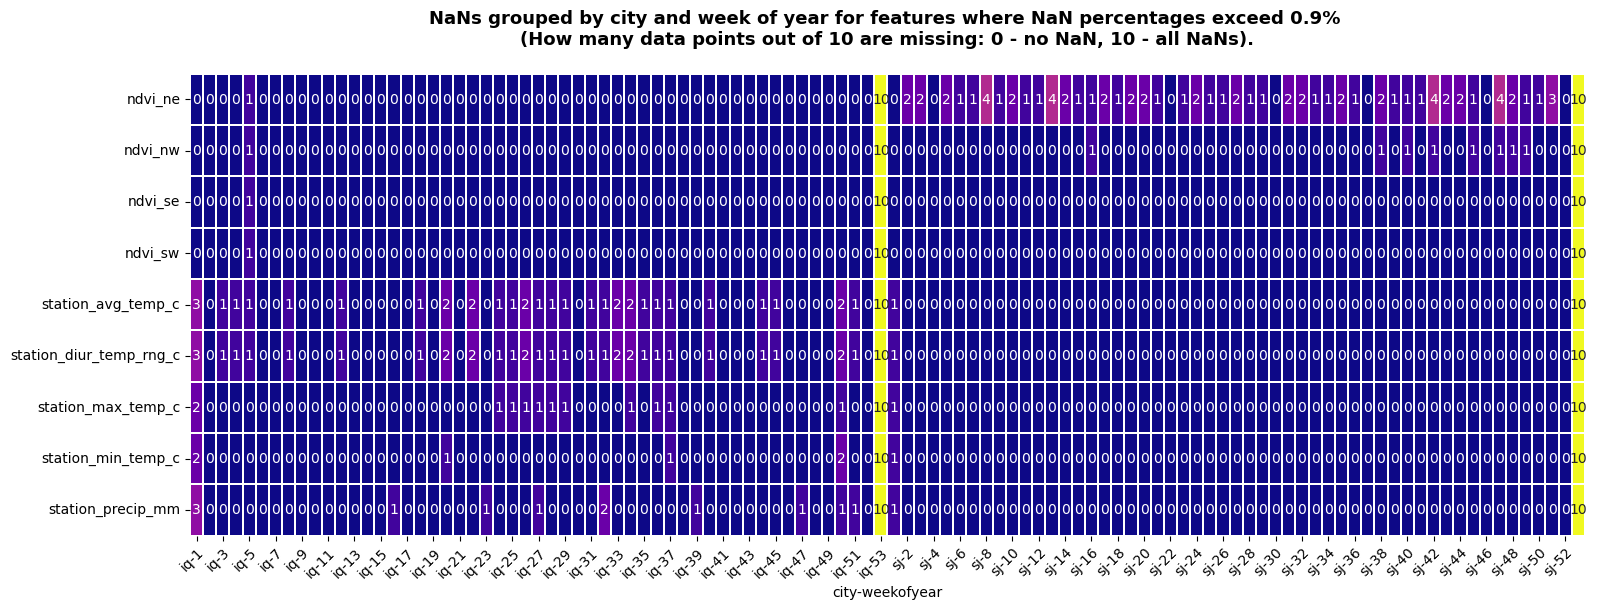

In [17]:
plt.figure(figsize=(18, 6))
sns.heatmap(df_train_raw_eda[high_nan_features]
    .isna()  # cannot be applied on groupby object later
    .groupby(by=[df_train_raw_eda[CITYGROUP_FEAT], df_train_raw_eda["weekofyear"]])
    .mean()  # calculate frequency proportion on boolean series
    .mul(10)  # multiply by 10 for visualizaton annotations
    .astype(int)
    .T,  # transform for visualization
            linewidths=0.01,
            annot=True,
            cmap='plasma',
            cbar=False)
plt.title(f"NaNs grouped by city and week of year for features where NaN percentages exceed {filter_threshold}% \
\n(How many data points out of 10 are missing: 0 - no NaN, 10 - all NaNs).\n", 
          fontsize=13, fontweight="bold")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

**Conclusions:** data misigness is acceptable:
- No single week of the year after separating city data subsets is missong more than 50% of data:
    - week of year median imputation is possible
- week 53 has all NaNs across top features that require NaN imputation. Potential dataset issue:
    - remove week 53 rows

In [18]:
# Moved to/Imported from src.utils.eda
# DELETE  for cleanup

# def compute_correlations_matrix(data: pd.DataFrame,
#                                annot: bool = False,
#                                figsize: tuple = (17, 5),
#                                 cmap:str = "PuBuGn"):
#     """
#     Compute and display a heatmap of the correlation matrix for numerical features.    
#     :param data: pandas DataFrame containing the input data.
#     :return: pandas DataFrame of the correlation matrix.
#     """
#     plt.figure(figsize=figsize)
#     correlation_matrix = data.select_dtypes(include="number").corr()
#     triangular_matrix = np.triu(correlation_matrix, k=1)

#     sns.heatmap(data=correlation_matrix,
#                 center=0,
#                 cmap=cmap,
#                 cbar=False,
#                 # cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
#                 annot=annot,
#                 linewidths=0.5,
#                 mask=triangular_matrix,
#                )
#     plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
#     plt.title("Correlation matrix for feature and target columns.",
#                 fontsize=18, fontweight='bold', y=0.95)
#     plt.tight_layout();

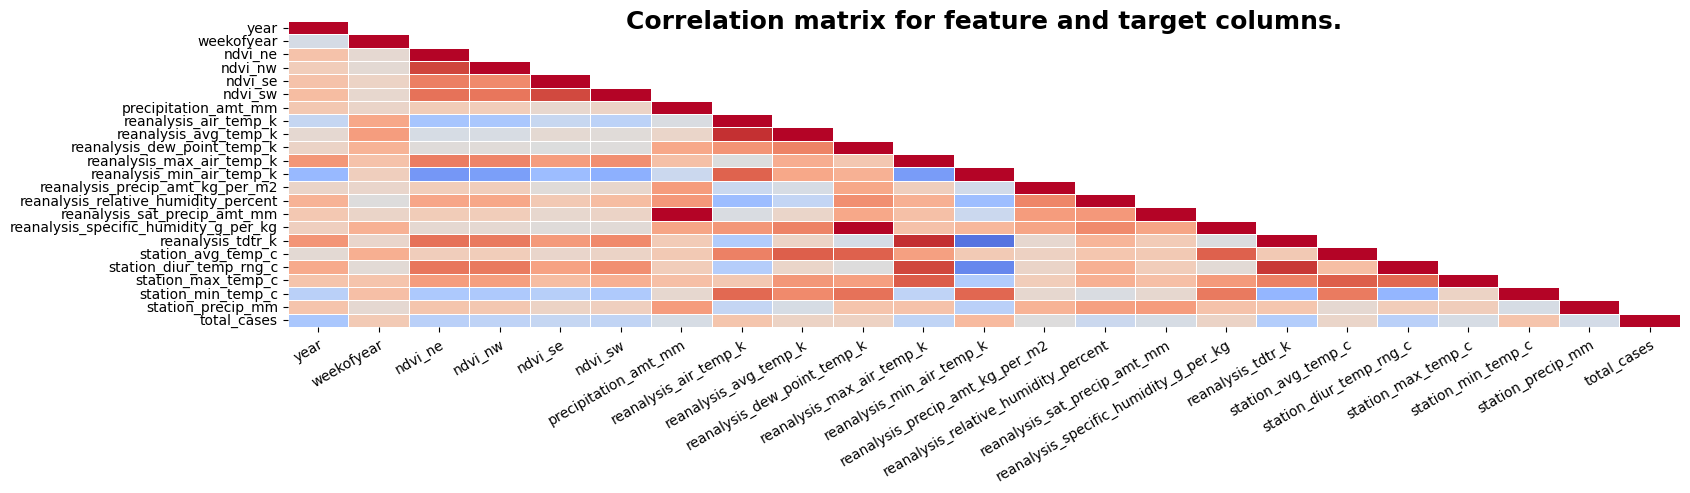

In [19]:
compute_correlations_matrix(
    data=pd.concat([df_train_raw_eda, df_labels_raw_eda[TARGET]], axis=1),
    cmap="coolwarm",
    # annot=True
)

In [20]:
# Moved to/Imported from src.utils.eda
# DELETE  for cleanup

# def top_correlations(data: pd.DataFrame, corr_threshold:float=0.95) -> pd.Series:
#     """
#     Identify and return highly correlated feature pairs above a specified threshold.
#     :param data: pandas DataFrame containing the input dataset. Defaults to df_clean.
#     :param corr_threshold: Correlation threshold to filter feature pairs. Default is 0.95.
#     :return: A pandas Series with multi-index (feature pairs) and correlation values.
#     """
#     correlations = data.select_dtypes(include="number").corr()
#     correlations = correlations.unstack().sort_values(ascending=False)
#     correlations = correlations[(correlations.abs() > corr_threshold) &
#         (correlations.index.get_level_values(0) != correlations.index.get_level_values(1))]
#     correlations = correlations.drop_duplicates()
#     return correlations

In [21]:
corr_threshold = 0.8
print(f"Features with correlation exceeding {corr_threshold}:")
top_correlations(
    data=df_train_raw_eda,
    corr_threshold=corr_threshold
)

Features with correlation exceeding 0.8:


precipitation_amt_mm         reanalysis_sat_precip_amt_mm             1.000000
reanalysis_dew_point_temp_k  reanalysis_specific_humidity_g_per_kg    0.997084
reanalysis_max_air_temp_k    reanalysis_tdtr_k                        0.920724
reanalysis_air_temp_k        reanalysis_avg_temp_k                    0.900762
station_diur_temp_rng_c      reanalysis_tdtr_k                        0.881798
ndvi_nw                      ndvi_ne                                  0.850241
reanalysis_max_air_temp_k    station_diur_temp_rng_c                  0.832441
ndvi_sw                      ndvi_se                                  0.823008
reanalysis_min_air_temp_k    reanalysis_tdtr_k                       -0.818228
dtype: float64

In [22]:
print(f"City-stratified correlations exceeding {corr_threshold}:")
df_train_raw_eda.groupby(
    by=CITYGROUP_FEAT).apply(
        lambda group: top_correlations(
            data=group, 
            corr_threshold=0.8
        ), include_groups=False)

City-stratified correlations exceeding 0.8:


city                                                                              
iq    precipitation_amt_mm                   reanalysis_sat_precip_amt_mm             1.000000
      reanalysis_dew_point_temp_k            reanalysis_specific_humidity_g_per_kg    0.997843
      reanalysis_avg_temp_k                  reanalysis_air_temp_k                    0.973187
      ndvi_ne                                ndvi_sw                                  0.842280
      reanalysis_max_air_temp_k              reanalysis_tdtr_k                        0.806808
      reanalysis_tdtr_k                      reanalysis_relative_humidity_percent    -0.897359
sj    precipitation_amt_mm                   reanalysis_sat_precip_amt_mm             1.000000
      reanalysis_dew_point_temp_k            reanalysis_specific_humidity_g_per_kg    0.998481
      reanalysis_avg_temp_k                  reanalysis_air_temp_k                    0.997385
      reanalysis_air_temp_k                  reanalysis_min_ai

 **Conclusions** a lot of multicolinearity:
- Multicolinearity is especially severe for `San Juan` subset that shows stronger climate correlations, especially within "reanalysis_" data (potentially satelite reanalysis models better tuned for particular geographical environment)
- Not an issue per se for LSTM, but introduces redundancy. Therefore:
    - Remove identical (same culprits in both subsets):
        -  "reanalysis_sat_precip_amt_mm" and near identical "reanalysis_dew_point_temp_k"
    - remove highly correlated infered feature:
        - "reanalysis_avg_temp_k"
    - keep potential cross domain feature despite high correlations:
        - "reanalysis_tdtr_k"
    - keep direct sation measurement data despite correlations with reanalysis data:
        - "station_diur_temp_rng_c"
    -  cluster vegetation in North and South features:
        - 'ndvi_ne' with 'ndvi_nw' and 'ndvi_se' with 'ndvi_sw (AFTER NaN interpolation)
- Conduct more in-depth city-stratified VIF (Variance Inflation Factor) assesment for one-vs-all relationships in cleaning process after NaN cleaning and initial feature removal based on assesment above. If VIF for any feature > 10 reasess further feature removal.

In [23]:
display_corr_thresh = 0.35
city_corr = df_train_raw_eda.groupby(by=CITYGROUP_FEAT).corr(numeric_only=True)
print(20*"=", f"Top correlations for features with more than {filter_threshold}% of NaNs.", 20*"=", "\n")
for feature in high_nan_features:
    print(10*"*", feature, 10*"*")
    display(city_corr[feature].drop(feature, level=1).sort_values(ascending=False).loc[lambda x: abs(x) > display_corr_thresh])
    print()
del city_corr

==================== Top correlations for features with more than 0.9% of NaNs. ==================== 

********** ndvi_ne **********


city         
iq    ndvi_sw    0.842280
      ndvi_se    0.769299
      ndvi_nw    0.765540
sj    ndvi_nw    0.673266
      year      -0.377620
Name: ndvi_ne, dtype: float64


********** ndvi_nw **********


city         
iq    ndvi_sw    0.765703
      ndvi_ne    0.765540
sj    ndvi_ne    0.673266
iq    ndvi_se    0.640803
sj    year      -0.478182
Name: ndvi_nw, dtype: float64


********** ndvi_se **********


city         
sj    ndvi_sw    0.821120
iq    ndvi_ne    0.769299
      ndvi_sw    0.716062
      ndvi_nw    0.640803
Name: ndvi_se, dtype: float64


********** ndvi_sw **********


city         
iq    ndvi_ne    0.842280
sj    ndvi_se    0.821120
iq    ndvi_nw    0.765703
      ndvi_se    0.716062
Name: ndvi_sw, dtype: float64


********** station_avg_temp_c **********


city                                       
sj    station_min_temp_c                       0.899446
      reanalysis_air_temp_k                    0.879449
      reanalysis_avg_temp_k                    0.877612
      reanalysis_specific_humidity_g_per_kg    0.867970
      reanalysis_dew_point_temp_k              0.866860
      station_max_temp_c                       0.856741
      reanalysis_max_air_temp_k                0.847520
      reanalysis_min_air_temp_k                0.837050
iq    station_max_temp_c                       0.651400
      reanalysis_air_temp_k                    0.598942
      reanalysis_avg_temp_k                    0.563941
      station_diur_temp_rng_c                  0.490938
sj    weekofyear                               0.487384
iq    station_min_temp_c                       0.455127
sj    reanalysis_relative_humidity_percent     0.441538
iq    reanalysis_min_air_temp_k                0.403197
      reanalysis_max_air_temp_k                0.377715
Name


********** station_diur_temp_rng_c **********


city                                      
iq    station_max_temp_c                      0.663098
      reanalysis_max_air_temp_k               0.585292
      reanalysis_tdtr_k                       0.577575
      reanalysis_avg_temp_k                   0.504496
      reanalysis_air_temp_k                   0.504423
      station_avg_temp_c                      0.490938
sj    station_max_temp_c                      0.453698
      reanalysis_tdtr_k                       0.377220
iq    reanalysis_relative_humidity_percent   -0.568074
Name: station_diur_temp_rng_c, dtype: float64


********** station_max_temp_c **********


city                                       
sj    station_avg_temp_c                       0.856741
      reanalysis_max_air_temp_k                0.754244
      reanalysis_avg_temp_k                    0.696024
      reanalysis_air_temp_k                    0.690098
      reanalysis_specific_humidity_g_per_kg    0.679179
      reanalysis_dew_point_temp_k              0.677925
      station_min_temp_c                       0.666115
iq    station_diur_temp_rng_c                  0.663098
      station_avg_temp_c                       0.651400
      reanalysis_air_temp_k                    0.632426
sj    reanalysis_min_air_temp_k                0.613011
iq    reanalysis_avg_temp_k                    0.609104
      reanalysis_max_air_temp_k                0.583941
sj    station_diur_temp_rng_c                  0.453698
iq    reanalysis_tdtr_k                        0.387752
      reanalysis_relative_humidity_percent    -0.374814
Name: station_max_temp_c, dtype: float64


********** station_min_temp_c **********


city                                       
sj    station_avg_temp_c                       0.899446
      reanalysis_dew_point_temp_k              0.853085
      reanalysis_specific_humidity_g_per_kg    0.852082
      reanalysis_air_temp_k                    0.830947
      reanalysis_min_air_temp_k                0.826580
      reanalysis_avg_temp_k                    0.825305
      reanalysis_max_air_temp_k                0.766995
      station_max_temp_c                       0.666115
iq    reanalysis_dew_point_temp_k              0.622599
      reanalysis_specific_humidity_g_per_kg    0.621366
      reanalysis_min_air_temp_k                0.590780
sj    weekofyear                               0.522365
      reanalysis_relative_humidity_percent     0.491687
iq    station_avg_temp_c                       0.455127
      reanalysis_relative_humidity_percent     0.358481
Name: station_min_temp_c, dtype: float64


********** station_precip_mm **********


city                                      
sj    reanalysis_sat_precip_amt_mm            0.565818
      precipitation_amt_mm                    0.565818
      reanalysis_precip_amt_kg_per_m2         0.474705
      reanalysis_relative_humidity_percent    0.450891
iq    precipitation_amt_mm                    0.377852
      reanalysis_sat_precip_amt_mm            0.377852
Name: station_precip_mm, dtype: float64

**Conclusions**: 
- vegetation features show high correlations. In Iqiutos, especially in Northern quadrants, correlations are higher than in San Juan.
- station measurement features: higher correlations with corresponding reanalysys features for San Juan than for Iqiutos.
- `station_precip_mm`, shows relatively week correlations with any other feature thus even more increasing its importance for dengue forecasting, 

In [24]:
# sns.pairplot(df_train_raw_eda, diag_kind="kde")  # resource demanding and creates notebook clutter

- #### Feature level EDA

***To reduce data snooping, slice last entries for both dataset cities***

In [25]:
holdout_pct = 0.05
cities_first_i = df_train_raw_eda.groupby(by=CITYGROUP_FEAT)["week_start_date"].idxmin()  # Series w Start indices
cities_last_i = df_train_raw_eda.groupby(by=CITYGROUP_FEAT)["week_start_date"].idxmax()  # Series w end indices
cities_last_i = (cities_last_i - (cities_last_i - cities_first_i) * holdout_pct).astype(int)  # indice math with Series
period = tuple(slice(cities_first_i[city], cities_last_i[city], 1) for city in cities_last_i.index[::-1])  # Create tuple of slices from 2 Series
df_train_raw_eda = df_train_raw_eda.iloc[np.r_[period]].reset_index(drop=True)  # apply defuned slices
df_labels_raw_eda = df_labels_raw_eda.iloc[np.r_[period]].reset_index(drop=True)

In [26]:
# Moved to/Imported from src.utils.eda
# DELETE  for cleanup

# def display_distributions(data: pd.DataFrame, features: List[str],
#                           fig_width: int = 17,
#                           hue_palette: Tuple[str | None, Any | None] = (None, None),
#                           x_range: Tuple[int,int] | None = None,
#                           title_prefix: str=None) -> None:
#     """Display distribution graphs for specified numerical features.
#     All subplots share the same x-axis scale.
#     :param data: DataFrames with numerical categories for visualization.
#     :param features: list of column names/features  from 'data' Dataframe.
#     :param hue_palette: Coloring by category. Use (None, None) for no hue 
#                 coloring (default).
#     :param x_range: Optional tuple (min, max) to set uniform x-axis limits 
#                 across all subplots (default: None, auto-scaled).
#     :param title_prefix: Optional, prefix for visualization title.
#     """
#     n_subplots = len(features) * 2
#     fig, axs = plt.subplots(nrows=n_subplots, figsize = (fig_width, n_subplots * 2), 
#                             sharex=True
#                            )                   
#     index = 0
#     for feature in features:
#         sns.boxenplot(data=data, x=data[feature],
#                       hue=hue_palette[0],
#                       palette=hue_palette[1],
#                       color=random_color(), 
#                       ax=axs[index])
#         sns.kdeplot(data=data, x=data[feature], fill=True,
#                       hue=hue_palette[0],
#                       palette=hue_palette[1],
#                     color=random_color(), 
#                     ax=axs[index + 1])
#         index += 2
        
#     if title_prefix is not None:
#         fig.suptitle(f"{title_prefix} feature distribution analysis.", fontsize=18,
#                     fontweight='bold', y=0.98)
#     else:
#         fig.suptitle("Feature distribution analysis.", fontsize=18,
#                     fontweight='bold', y=0.98)

#     if x_range is not None:
#         axs[0].set_xlim(x_range)
        
#     fig.tight_layout();

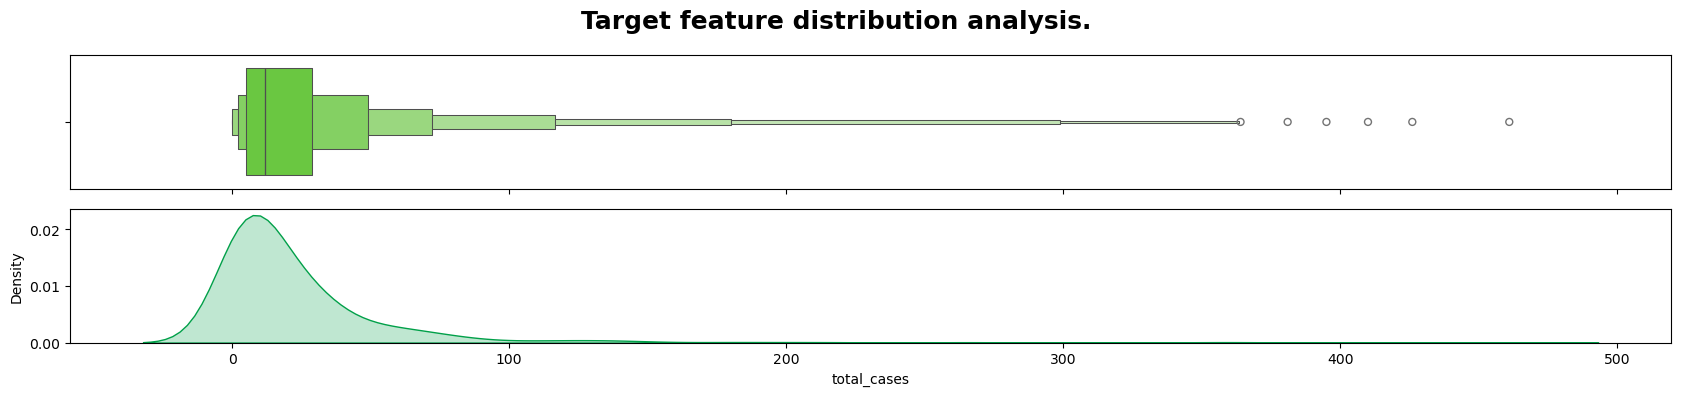

In [27]:
display_distributions(df_labels_raw_eda, features=[TARGET], title_prefix="Target")

**Conclusion** Skew + outliers:

**Preprocessing tactics for outliers:**
- Target ("total_cases")
    - If tree models used (eg LightGBM) - no issue, trees are not sensitive to outliers:
        - use huber loss for extra safety when handling tails
        - clip extreme values for dengue context realistic predictions
        - RobustScaler may be redunndant for tree models, but if it simplifies pipeline - no harm.
    - RNNs (eg LSTM) are outlier sensitive (gradient instability, hidden state patterns loose importance at peaks, scaling):
        - Log transform
        - Scale (RobustScaler  with IQR is more outlier resistant)
        - apply huber loss
    - clip (!= remove) extreme values for target for both models, separate clipping by city (outlier in Iquitos may not be an outlier in much larger San Juan)
- Features:
    - clip globally (less complex, city specific can mess up transfer learning
    - clip for both tree and RNN
    - RobustScaler for RNN
    - RobustScaler may be redunndant for tree models, but if it simplifies pipeline - no harm.
        - rainfall:
            - clip to ~ 300 mm (test 99.5 percentile)
        - temperature:
           - are specific extremes are from 20 - 40 C (test 99.5 percentile)
           - clip min to ~ 20
           - clip max to ~ 40
        - vegetation (ndvi features)
            - dataset ranges from -0.456100 (water bodies) to 0.546017 (rainforest) are possible
            - no need for clipping, but can apply IQR clip as preventive measure for future data/prediction inputs

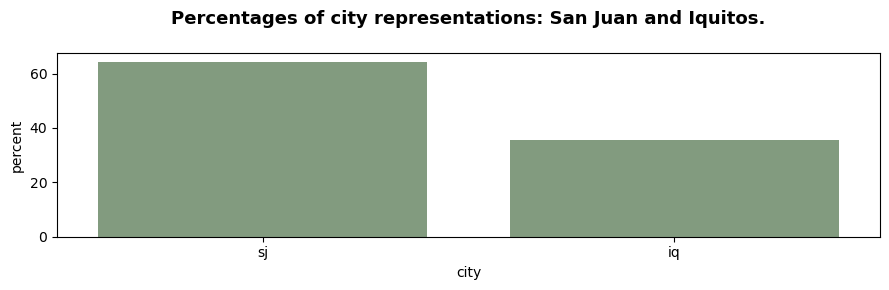

In [28]:
plt.figure(figsize=(9, 3))  # df_train_raw_eda.shape[1]
sns.countplot(data=df_labels_raw_eda, x=CITYGROUP_FEAT, color=random_color(),
             stat="percent"
             )
plt.title("Percentages of city representations: San Juan and Iquitos.\n", 
          fontsize=13, fontweight='bold')
plt.tight_layout();

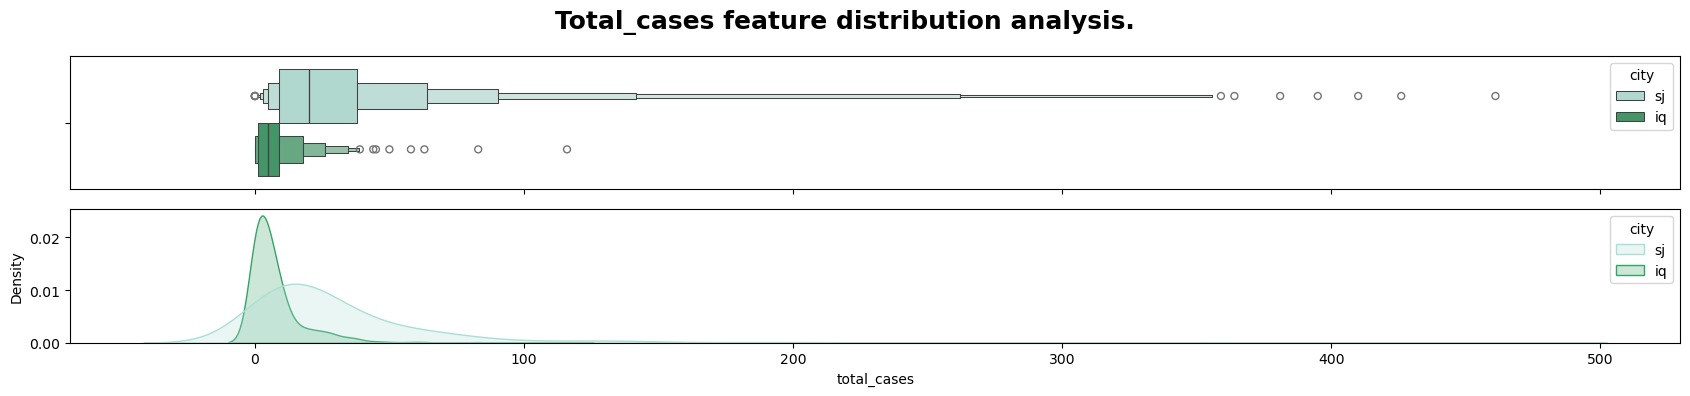

In [29]:
# for assign indices must match as they do for df_train_raw_eda and df_labels_raw_eda
display_distributions(data = df_labels_raw_eda.assign(city=df_train_raw_eda[CITYGROUP_FEAT]),
                      hue_palette=(CITYGROUP_FEAT, random_colormap()),
                     features=[TARGET], title_prefix=TARGET.capitalize(),
                     )

**Conclusions**: Dengue case distribution patterns in both cities are similar, however:
- San Juan has wider Dengue case range
- San Juan has higher Dengue case counts
- San Juan has more data
- As San Juan has both - more data and wider range, use San Juan dataset for pretraining.

***Distributions of selected numerical fatures***:
- except inferred reanalysis features
- except vegetation features
- features with least normal distributions selected for this visualization and analisys
- outliers in every feature

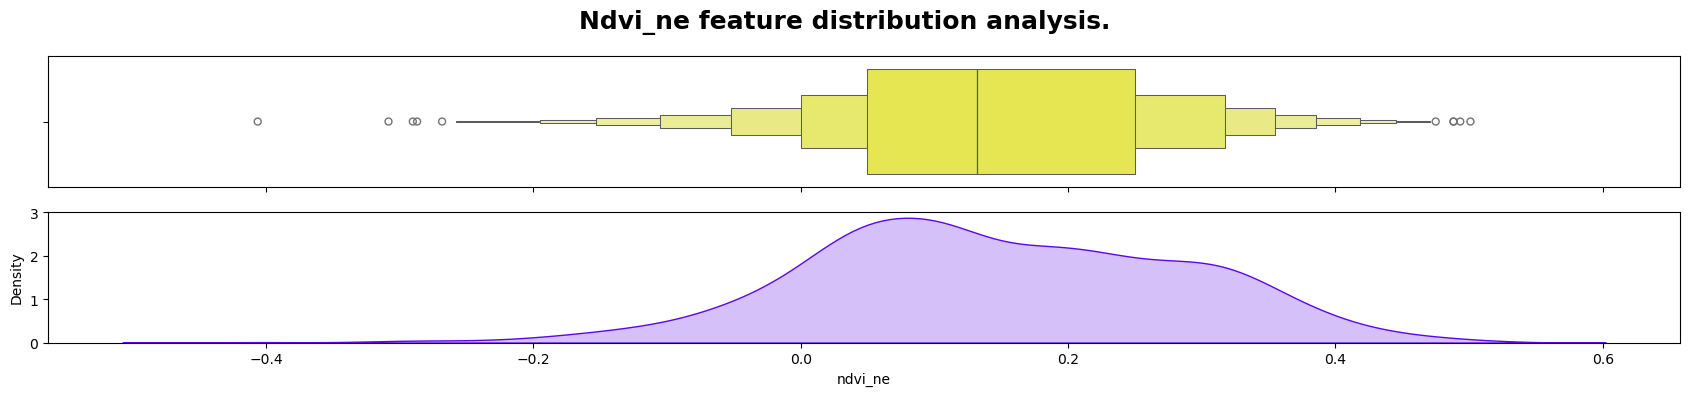

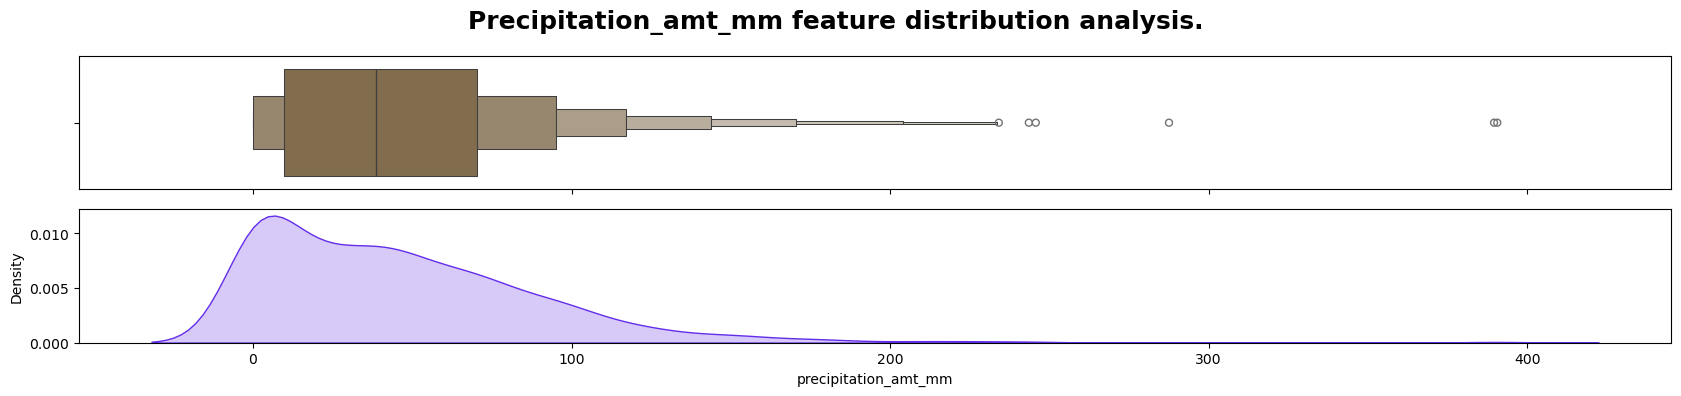

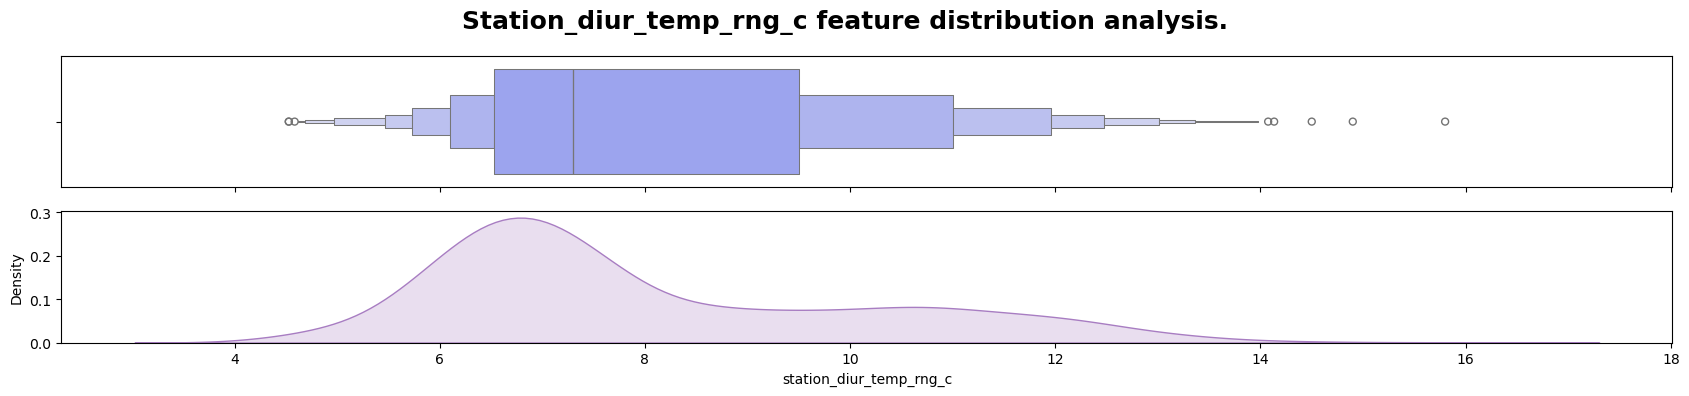

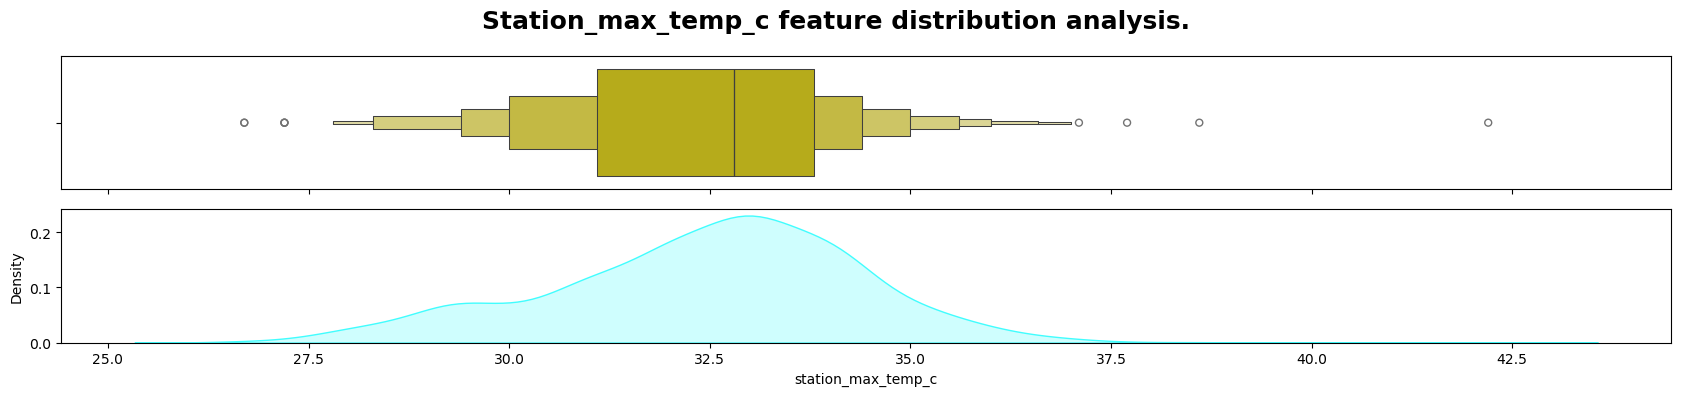

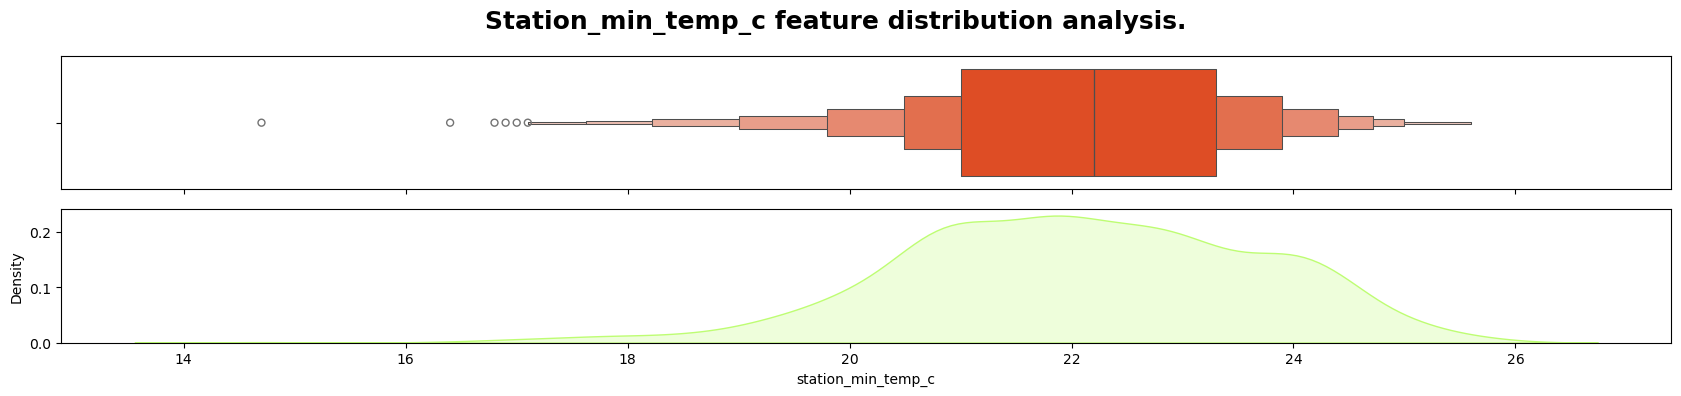

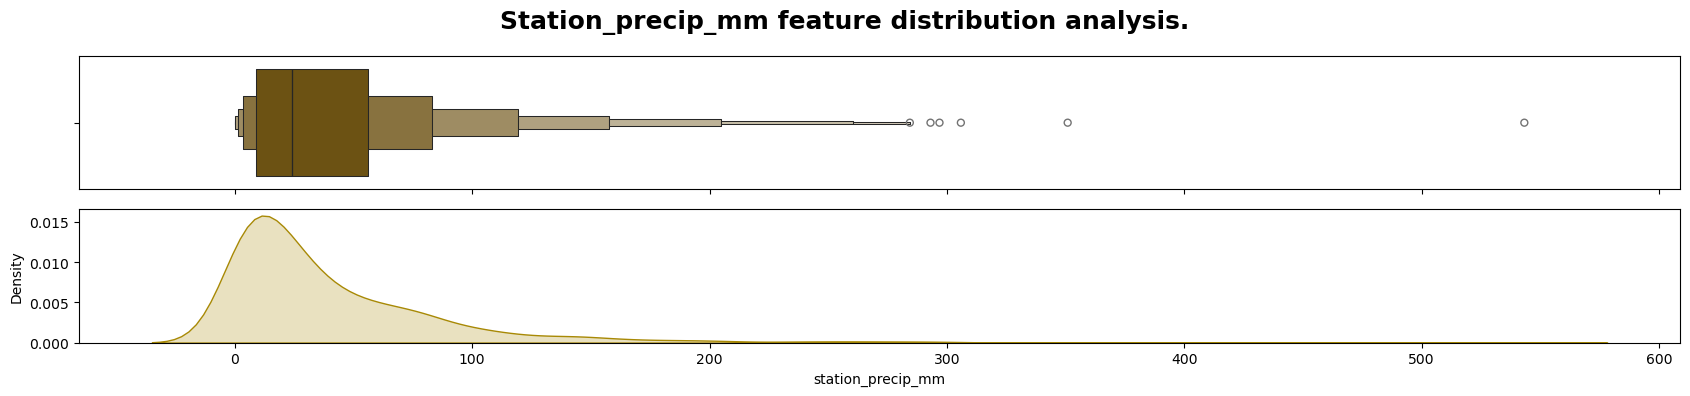

In [30]:
selected_distro_EDA_features = ["ndvi_ne", "precipitation_amt_mm", "station_diur_temp_rng_c", "station_max_temp_c",
       "station_min_temp_c", "station_precip_mm"]
# selected_distro_EDA_features = [feature for feature in df_train_raw_eda.select_dtypes("float") if not feature.startswith("reanalysis")]  # used for outlier check

for numeric_feature in selected_distro_EDA_features:
    display_distributions(data=df_train_raw_eda[selected_distro_EDA_features],
                          features=[numeric_feature],
                          title_prefix=numeric_feature)

**Conclusion**:
- Distributions are fairly Normal even for the most bimodal features
- Some of this multi-modality can be explained by different modes between San Juan and Iquitos data:
    - Even more reason to experiment with training datasets separately
-   station_precip_mm distribution look very similar to target distribution - both in shape and in values

***Comparative distributions for city level numerical fatures, except inferred reanalysis features***
- station_avg_temp_c (ilustrates if the city is within dengue friendly 27-31C range)
- station_precip_mm - local sation level rainfall data
- ndvi_avg - average of vegetation quadrant data to ilustrate cities

**Conclusion** San Juan and Iquitos cities have distinct data distributions in all selected features, indicating more rain, more vegetation and slightly higher temperatures in Iquitos.

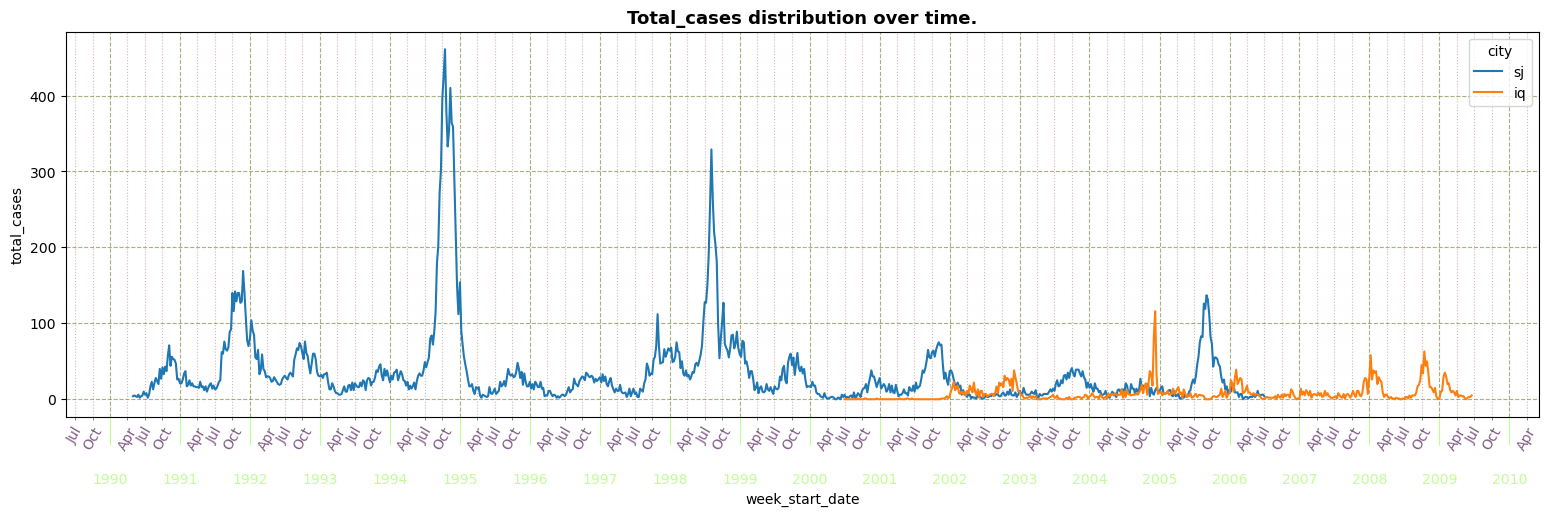

In [31]:
# Moved to/Imported from src/utils/visualizations.py
# DELETE  for cleanup

# def display_timeseries(data: pd.DataFrame, x: str, y: str,
#                         hue: str | None = None, grid: bool = True,
#                         shift: int | None = None,
#                         month_ticks: Tuple[int, ...] = (1,4,7,10),
#                         title_prefix: str | None = None) -> None:
    
#     """
#     Display timeseries line plots for specified features.
#     All subplots share the same x-axis scale.
    
#     :param data: DataFrame with numerical categories for visualization.
#     :param x: Column name for x-axis (datetime).
#     :param y: Column name for y-axis.
#     :param hue: Optional column name for hue coloring (default: None).
#     :param shift: Optional number of weekly periods to shift the time axis 
#             for an overlaid comparison line.
#     :param grid: Whether to show grid lines (default: True).
#     :param month_ticks: Tuple of month numbers for minor x-axis ticks (default: (1,4,7,10) quarterly).
#     :param title_prefix: Optional, prefix for visualization title.
#     """
    
#     fig, ax = plt.subplots(figsize=(19, 5))
#     sns.lineplot(data=data, x=x, y=y, hue=hue)
    # if shift is not None:
    #     shifted_data = data[[x, y, hue]]
    #     shifted_data[x] = shifted_data[x] + pd.Timedelta(52, "W")
    #     sns.lineplot(data=shifted_data, x=x, y=y, hue=hue, linestyle=":")
        
#     # # Configure x-axis ticks (quarterly minors, yearly majors)
#     ax.xaxis.set_minor_locator(MonthLocator(bymonth=month_ticks))  
#     ax.xaxis.set_minor_formatter(DateFormatter(fmt="%b"))
#     ax.xaxis.set_major_locator(YearLocator())
    
#     # Prettu Alternative:
#     # ax.xaxis.set(major_locator=YearLocator(),
#     #              minor_locator=MonthLocator(bymonth=month_ticks),  # qarterly ticks
#     #              minor_formatter=(DateFormatter(fmt="%b")))
        
    
#     # Style ticks
#     ax.tick_params(axis='x', which="major", pad=20, length=20,
#                    colors=random_color()  # remove for cleanup
#                   )
#     ax.tick_params(axis='x', which="minor", labelrotation=60,
#                   colors=random_color()  # remove for cleanup
#                   )
    
#     # Grid styling
#     if grid:
#         plt.grid(alpha=0.7,
#             linestyle="dashed",
#             color=random_color()  # remove for cleanup
#         )
#         plt.grid(alpha=0.5, axis='x', which="minor", linestyle="dotted",
#                 color=random_color()  # remove for cleanup
#                 )

#     if title_prefix is not None:
#         plt.title(f"{title_prefix} distribution over time.",
#                     fontsize=13, fontweight="bold");
#     else:
#         plt.title("Target distribution over time.",
#                  fontsize=13, fontweight="bold");

# for assign indices must match as they do for df_train_raw_eda and df_labels_raw_eda

display_timeseries(data=df_train_raw_eda[[CITYGROUP_FEAT, "week_start_date"]].assign(total_cases=df_labels_raw_eda[TARGET]),
                   x="week_start_date",
                   y=TARGET,
                   hue=CITYGROUP_FEAT,
                   title_prefix=TARGET)

In [32]:
df_train_raw_eda["week_start_date"].duplicated().sum()

313

In [33]:
for _, df in df_train_raw_eda.groupby(by=CITYGROUP_FEAT):
    print(df["week_start_date"].duplicated().sum())

0
0


**Conclusions**:
- time data do overlap for some 1/4 rows - when separated by cities, no duplications:
    - not an issue for tree based models
    - for RNN need to encode numerical city feature
    - for city-wise transfer learning - overlaping dates is an asset
- zero values for almost 1.5 initial years in Iquitos
- After initial low value period case counts in Iquitos become more variable.
- Some annual patterns in San Juan
- Outbreak seasons differ for san Juan and Iquitos:
    - consider cyclical time feature engineering

In [34]:
for city, df in df_labels_raw_eda.groupby(by=CITYGROUP_FEAT):
    print(f"Zero target values in {city}: {len(df[df[TARGET] == 0])}")

Zero target values in iq: 91
Zero target values in sj: 4


**Conclusion**: Insignificant zero 'total_case' values in San Juan

In [35]:
zero_one_targets = value_streaks(data=df_labels_raw_eda, column=TARGET, value=range(2),
                             run_threshold=5)
print("Zero and one consecutive value streaks for target data ('total dengue cases).")
zero_one_targets

Zero and one consecutive value streaks for target data ('total dengue cases).


,first_pos,last_pos,streak_len
0,842,916,75
1,985,993,9
2,1001,1006,6
3,1253,1258,6


In [36]:
print("Target data for second longest low value streak.")
df_labels_raw_eda.iloc[zero_one_targets["first_pos"][1]:zero_one_targets["last_pos"][1] + 1]

Target data for second longest low value streak.


,city,year,weekofyear,total_cases
985,iq,2003,14,0
986,iq,2003,15,0
987,iq,2003,16,0
988,iq,2003,17,0
989,iq,2003,18,1
990,iq,2003,19,1
991,iq,2003,20,1
992,iq,2003,21,1
993,iq,2003,22,1


**Conclusion** There is a single 75 week long low value (0 and 1, mostly 0) for target 'total_case' data in  Iquitos. Next longest streak of 9 weeks already appears more aligned for low-infection period in sparsely populated place with mostly single infection data:
   - such imbalance over long time period, especially at the beginning of dataset, can degrade feedforward ML model performance:
       - LightGBM slightly underpredicting
       - LSTM model has more serious failure risks: predicts delayed or damped peaks

**Preprocessing tactics for low value target streaks**:
1. Feature engineer flag for early period's low values (ie `iq_initial_low_case_streak`)
2. Predict log1p(total_cases) to reduce zero target influence
3. (Optional) LSTM specific - if LSTM results are sub-optimal, experiment with downweighting affected period data (ie 0.3 or more)

In [37]:
# Graph too saturated

# display_timeseries(data=df_train_raw_eda[[CITYGROUP_FEAT, "week_start_date"]].assign(total_cases=df_labels_raw_eda[TARGET]),
#                    x="week_start_date",
#                    y=TARGET,
#                    hue="CITYGROUP_FEAT,
#                    shift=52,
#                    title_prefix=f"{TARGET} and {TARGET} shifted by year")

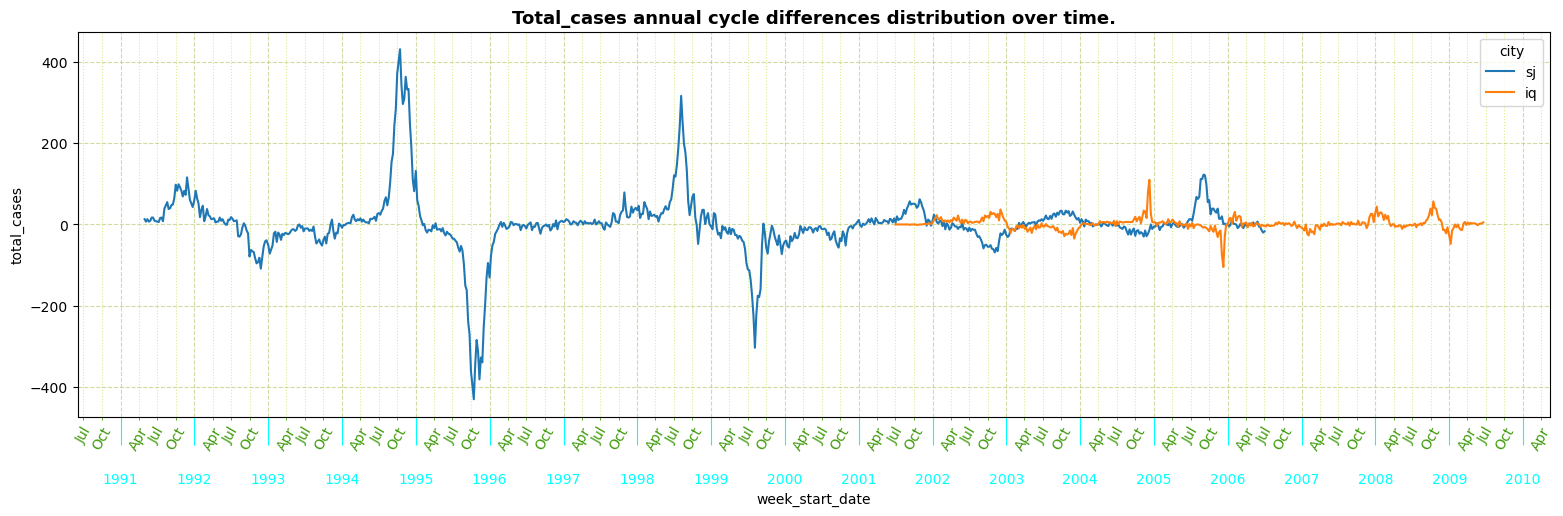

In [38]:
# a better way to display annual differences
# for assign indices must match as they do for df_train_raw_eda and df_labels_raw_eda
diff_weeks = 52 # for featture engineering/stationary data ise 1
display_timeseries(data=df_train_raw_eda[[CITYGROUP_FEAT, "week_start_date"]].assign(total_cases=df_labels_raw_eda.groupby(by=CITYGROUP_FEAT)[TARGET].diff(diff_weeks)),
                   x="week_start_date",
                   y=TARGET,
                   hue=CITYGROUP_FEAT,
                   title_prefix=f"{TARGET} annual cycle differences")

**Conclusion** There some annual patterns in San Juan (approx 2 yeare out of 20) and relatively more in Iquitos (approx 4 years out of 9):
- near zero values indicate annual patter streaks
- spikes indicate differences (most likely outbreak years):
    - San Juan has more outbreak patterns
- Tree models may handle such an interrupted seasonality better, but:
    - with adittional feature engineering:
      - seasonal cyclical sin/cos features (weekly on annual basis)
      - weekly autocorrelation/shift() (must) or annual shift features (indicate time momentum for tree model):
          - trees can handle resulting NaNs
      - weekly per city differencing to hughlight spikes and sudue seasonality - stationary (constant statistical properties over time) benefit trees.
      - Optional: annual diff feature for outbreak signals per city
-  RNNs (eg LSTM) will struggle with outbreak spikes as works best with smooth seasonal patterns:
    - still may benefit from  cyclical sin/cos features

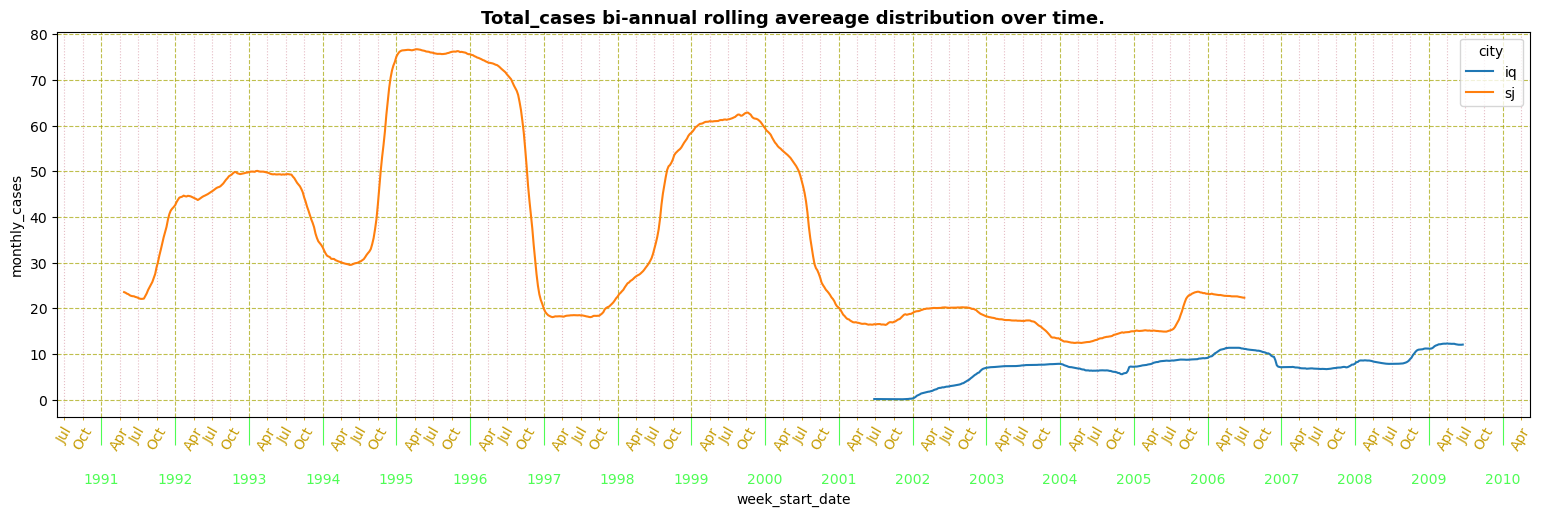

In [39]:
# for assign indices must match as they do for df_train_raw_eda and df_labels_raw_eda
weeks_to_average = 104  # bi-annual baseline, use shorter periods for outbreak capture (eg 13)
df_train_monthly = df_train_raw_eda[[CITYGROUP_FEAT, "week_start_date"]]\
    .assign(monthly_cases=df_labels_raw_eda[TARGET])\
        .groupby(by=CITYGROUP_FEAT)\
            .rolling(window=weeks_to_average,
                     min_periods=int(weeks_to_average / 2),
                     on="week_start_date")\
                .mean()

display_timeseries(data=df_train_monthly,
                   x="week_start_date",
                   y="monthly_cases",
                   hue=CITYGROUP_FEAT,
                   # grid=False,
                   title_prefix=f"{TARGET} bi-annual rolling avereage")
del df_train_monthly

**Conclusions**:
- Outbreak spikes still dominate
- No signifficant long term trends:
    - good as does not 'pollute' outbreak prediction
    - slight upward trend in Iquitos not signifficant:
        - ~ 1 case per year
        - will be partially mitigated after initial zero/low value streak is processed (ie flag + log1p)